very loosely based on https://keras.io/examples/vision/mnist_convnet/

In [ ]:
outdim=4

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
bx_train = np.expand_dims(x_train, -1)
bx_test = np.expand_dims(x_test, -1)
print("x_train shape:", bx_train.shape)
print(bx_train.shape[0], "train samples")
print(bx_test.shape[0], "test samples")


# convert class vectors to binary class matrices
by_train = keras.utils.to_categorical(y_train, num_classes)
by_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
classes=[0,1]
x_train=np.array(
    [xx for xx,yy in zip(bx_train,by_train) if
      np.any([yy[cc] for cc in classes])
    ])
y_train=np.array([yy for yy in by_train if np.any([yy[cc] for cc in classes])])
print(x_train.shape)
print(y_train.shape)

xa_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      not np.any([yy[cc] for cc in classes])
    ])
ya_test=np.array([yy for yy in by_test if not np.any([yy[cc] for cc in classes])])
print(xa_test.shape)
print(ya_test.shape)
xn_test=np.array(
    [xx for xx,yy in zip(bx_test,by_test) if
      np.any([yy[cc] for cc in classes])
    ])
yn_test=np.array([yy for yy in by_test if np.any([yy[cc] for cc in classes])])
print(xn_test.shape)
print(yn_test.shape)



(12665, 28, 28, 1)
(12665, 10)
(7885, 28, 28, 1)
(7885, 10)
(2115, 28, 28, 1)
(2115, 10)


In [ ]:
def loss(outdim):
    if outdim==1:
        def lss(a,b):
            q=b
            return K.mean((q-1)**2)
        return lss
    def lss(a,b):
        q=b
        pd=[i for i in range(len(q.shape))]
        pd.remove(pd[-1])
        pd.insert(0,len(pd))
        #print(pd)
        q=K.permute_dimensions(q,tuple(pd))
        #exit()

        #print(q.shape)

        adl=None

        for i in range(outdim):
            for j in range(i+1,outdim):
              ac=K.abs(K.mean(((q[i]-1)*(q[j]-1))))
              if adl is None:
                  adl=ac
              else:
                  adl+=ac

        return adl
    return lss

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(16, kernel_size=(4, 4), activation="relu",use_bias=False),
        layers.Conv2D(4, kernel_size=(2, 2), activation="relu",use_bias=False),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(4,kernel_size=(1,1),activation="linear",padding="same",use_bias=False),
        layers.Flatten(),
        layers.Dense(outdim,use_bias=False)
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 16)          16384     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 4)           256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 4)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 4)           1

In [ ]:
batch_size = 128
epochs = 5

model.compile(loss=loss(outdim), optimizer="adam", metrics=[])

model.fit(x_train,
          np.ones_like(x_train),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Epoch 1/5
90/90 [==============================] - 13s 132ms/step - loss: 0.5017 - val_loss: 0.0342
Epoch 2/5
90/90 [==============================] - 12s 129ms/step - loss: 0.0166 - val_loss: 0.0211
Epoch 3/5
90/90 [==============================] - 12s 129ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 4/5
90/90 [==============================] - 12s 128ms/step - loss: 0.0058 - val_loss: 0.0067
Epoch 5/5
90/90 [==============================] - 12s 129ms/step - loss: 0.0047 - val_loss: 0.0046


In [ ]:
pa=model.predict(xa_test)
pn=model.predict(xn_test)

In [ ]:
print(pa.shape)
print(pn.shape)

(7885, 4)
(2115, 4)


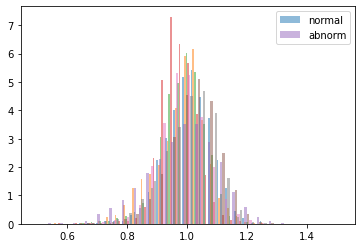

In [ ]:
import matplotlib.pyplot as plt
plt.hist(pn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(pa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
def dexbyloss(lss):return np.argmin(np.mean((pn-lss)**2,axis=1))
minl=np.min(pn,axis=0)
maxl=np.max(pn,axis=0)
print(minl,maxl)
ls=[np.arange(aminl,amaxl,(amaxl-aminl)/9.0001) for aminl,amaxl in zip(minl,maxl)]
print(minl,ls,maxl)
print(len(ls))

[0.6454242  0.5698406  0.64419556 0.5474965 ] [1.2678282 1.2588519 1.2046391 1.1700186]
[0.6454242  0.5698406  0.64419556 0.5474965 ] [array([0.64542419, 0.71457942, 0.78373466, 0.85288989, 0.92204513,
       0.99120037, 1.0603556 , 1.12951084, 1.19866607, 1.26782131]), array([0.56984061, 0.64639657, 0.72295253, 0.79950848, 0.87606444,
       0.9526204 , 1.02917636, 1.10573231, 1.18228827, 1.25884423]), array([0.64419556, 0.70646637, 0.76873718, 0.83100799, 0.8932788 ,
       0.95554961, 1.01782042, 1.08009123, 1.14236204, 1.20463285]), array([0.5474965 , 0.61666485, 0.6858332 , 0.75500154, 0.82416989,
       0.89333824, 0.96250659, 1.03167494, 1.10084329, 1.17001164])] [1.2678282 1.2588519 1.2046391 1.1700186]
4


In [ ]:
def moduloop(q,modulo=1):
  i,j=0,0
  while True:
    yield q[i]
    j+=1
    if not (j%modulo):
      i+=1
      i=i%len(q)

def allcomb(q):
  modulo=1
  iterators=[]
  for zw in q:
    iterators.append(moduloop(zw,modulo))
    modulo*=len(zw)
  for i in range(modulo):
      yield [zw.__next__() for zw in iterators]


In [ ]:
bids=[[0,1,2,3,4,5,6,7,8,9] for zw in ls]




x,y=[],[]

for bid,lss in zip(allcomb(bids),allcomb(ls)):
  x.append(bid)
  y.append(dexbyloss(lss))

x=np.array(x)
y=np.array(y)

cls=np.array([np.argmax(yn_test[yy]) for yy in y])

print(x.shape,y.shape,cls.shape)



(10000, 4) (10000,) (10000,)


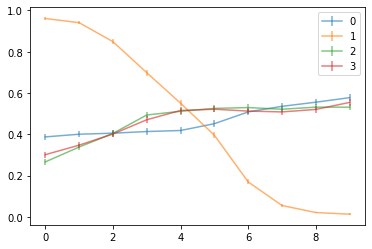

In [ ]:
for dim in range(outdim):
  mns,stds=[],[]
  for val in range(10):
    dex=np.where(x[:,dim]==val)
    vals=cls[dex]
    mn=np.mean(vals)
    std=np.std(vals)/np.sqrt(len(vals))
    mns.append(mn)
    stds.append(std)
    #print(f"x{dim}={val}:{mn}+-{std}")
  plt.errorbar(range(10),mns,yerr=stds,label=dim,alpha=0.6)
plt.legend()
plt.show()

In [ ]:
p=model.predict(x_train)


In [ ]:
mp=np.mean(p,axis=0)
da=np.abs(pa-mp)
dn=np.abs(pn-mp)
dfa=np.sqrt(np.mean(da**2,axis=1))
dfn=np.sqrt(np.mean(dn**2,axis=1))
print(dfa.shape,dfn.shape)

(7885,) (2115,)


In [ ]:
print("normal",np.mean(dfn),np.std(dfn))
print("abnorm",np.mean(dfa),np.std(dfa))

normal 0.06843601 0.029676534
abnorm 0.09012459 0.03925523


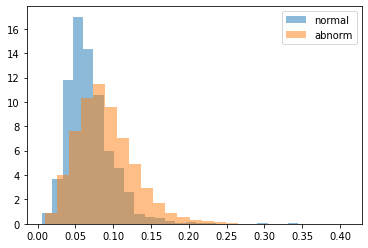

In [ ]:
plt.hist(dfn,bins=25,alpha=0.5,label="normal",density=True)
plt.hist(dfa,bins=25,alpha=0.5,label="abnorm",density=True)
plt.legend()
plt.show()

In [ ]:
y_score=np.concatenate((dfn,dfa),axis=0)
y_true=np.concatenate((np.zeros_like(dfn),np.ones_like(dfa)),axis=0)

print(y_true.shape,y_score.shape)

(10000,) (10000,)


In [ ]:
from sklearn.metrics import roc_auc_score as rauc

auc=rauc(y_true,y_score)
print(auc)

0.6780450057040406
